In [2]:
from torchvision.io import read_image
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import pytorch_lightning as pl

# Models and pre-trained weights
[Additional Reading](https://pytorch.org/vision/stable/models.html)

The torchvision.models subpackage contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.

In [ ]:
from torchvision import models
dir(models)

### Initializing pre-trained models

In [ ]:
#if you get ssl error run following
#import ssl
#ssl._create_default_https_context = ssl._create_stdlib_context

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

 resnet.eval()# we will be using the model for evaluation not training. This step is important as some models have different behaviour at traing and eval time

In [ ]:
weights=models.ResNet50_Weights.DEFAULT
weights.meta["categories"]

### Using the pre-trained models
Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

[Reference](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

mountain bike: 22.654999792575836%


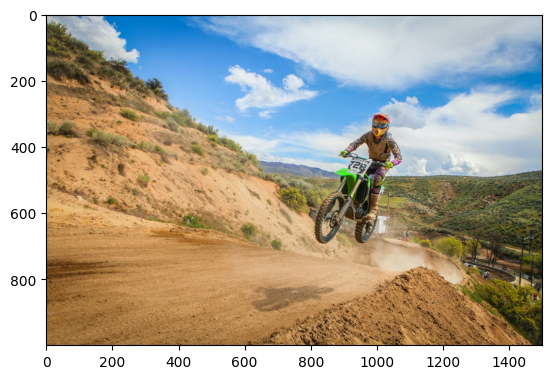

In [8]:
# Initialize the Transforms (preprocessing)
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

# Read image using Pytorch read_image
img = read_image('./data/images/motorbike.jpeg')

### or get the image from internet using the following:
#from PIL import Image
#import requests
#img = Image.open(requests.get('http://farm8.staticflickr.com/7090/7399887950_8845d3e6e4_z.jpg', stream=True).raw)


# Apply the preprocessing to the input image. Preprocess accepts Pytorch tensor or PIL image
batch = preprocess(img).unsqueeze(0) # unsqueeze will reshape the tensor to the correct shape

# Apply the model to the image
prediction = resnet(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score}%")

# Display the image
plt.imshow(transforms.ToPILImage()(img))
#plt.imshow(img) #if the img is already a PIL image

In [ ]:
resnet

## Fine tuning
Rather than training from scratch, the preferred technique is transfer learning, achieved by fine-tuning pre-trained models on custom datasets. By following this approach we use their existing knowledge and tailor them to our specific tasks, thereby conserving significant time and computational resources

In [14]:
num_classes = 10 # let say we want to finetune resnet on a dataset containing 10 classes

# Load pre-trained model 
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

# Freeze layer weights
for param in model.parameters():
    param.requires_grad = False
    
# Modify the model head for fine-tuning
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)


In [16]:
# Dataset
torch.manual_seed(0)
transform=transforms.Compose([transforms.ToTensor(),
                              preprocess])
trainset = datasets.CIFAR10(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

100%|█████████████████████████| 170498071/170498071 [03:23<00:00, 839587.84it/s]


Extracting /Users/oarif/Downloads/cifar-10-python.tar.gz to /Users/oarif/Downloads/
Files already downloaded and verified


In [19]:
class LitModel(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.criteria = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criteria(outputs, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criteria(outputs, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [21]:

# initialize the lightning module
lit_model = LitModel(model, lr=1e-3)

# optionally wrap loaders if needed
# (your trainloader and testloader are already fine)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",  # uses GPU if available
    devices="auto",
    log_every_n_steps=5,
)

# train and validate
trainer.fit(lit_model, train_dataloaders=trainloader, val_dataloaders=testloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | ResNet           | 23.5 M | train
1 | criteria | CrossEntropyLoss | 0      | train
------------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/oarif/Documents/workspace/COE49413/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/oarif/Documents/workspace/COE49413/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
# Evaluation

correct = 0
total = 0

lit_model.eval()  # set model to evaluation mode

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(lit_model.device)
        labels = labels.to(lit_model.device)
        outputs = lit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

Accuracy of the network on the test images: 81.33%
